### Mini-Batch Gradient Descent para entrenar un modelo cuadrático
#### Implementar el ejercicio 2 de la Clase 2 utilizando PyTorch

In [14]:
# Importamos las librerías
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

In [15]:
import torchsummary
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [16]:
#Definimos la clase para armar el dataset similar al del TP de la clase 2, según la consigna
class Data(Dataset):
    
    def __init__(self, n=10000):
        x = np.random.uniform(0,4,n)
        y = -(x-2)**2 + 3 + .2*np.sin(16*x)
        self.y = torch.from_numpy(y).type(torch.Tensor)
        self.x = torch.from_numpy(x).type(torch.FloatTensor)
        self.len = y.shape[0]
    
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

In [17]:
# Definimos un modelo de dos capas ocultas y una salida contínua, con activación de tangente hiperbólica.
class modelo(nn.Module):
    def __init__(self):
        super().__init__()  # <1>
        
        self.hidden_linear = nn.Linear(1, 20)
        self.hidden_activation = nn.Tanh()
        self.hidden2_linear = nn.Linear(20, 10)
        self.hidden2_activation = nn.Tanh()
        self.output_linear = nn.Linear(10, 1)
        
    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = self.hidden_activation(hidden_t)
        hidden_t2 = self.hidden2_linear(activated_t)
        activated_t2 = self.hidden2_activation(hidden_t2)
        output_t = self.output_linear(activated_t2)
        
        return output_t
    
modeloTP3= modelo()
torchsummary.summary(modeloTP3, input_size=(10000, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 10000, 20]              40
              Tanh-2            [-1, 10000, 20]               0
            Linear-3            [-1, 10000, 10]             210
              Tanh-4            [-1, 10000, 10]               0
            Linear-5             [-1, 10000, 1]              11
Total params: 261
Trainable params: 261
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 4.65
Params size (MB): 0.00
Estimated Total Size (MB): 4.69
----------------------------------------------------------------


In [18]:
# Definimos la función de entrenamiento
def train(data_set,model,criterion, train_loader, optimizer, epochs=5,plot_number=10):
    cost=[]
    
    for epoch in range(epochs):
        total=0
        
        for x,y in train_loader:
            
            # batch_size = 100
            # x=(100, 1), y=(100,1)

            optimizer.zero_grad()
            
            yhat=model(x)
            loss=criterion(yhat,y)
            loss.backward()
            optimizer.step()
            total+=loss.item()
            #print(loss)
            
        if epoch%plot_number==0:
            print(total)
        
        cost.append(total)
    plt.figure()
    plt.plot(cost)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.show()
    return cost


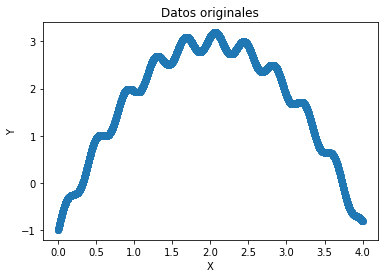

In [23]:
# Creamos nuestro dataset

data_set = Data()

data_set.y = data_set.y.view(-1,1)
data_set.x = data_set.x.view(-1,1)
plt.ylabel('Y')
plt.xlabel('X')
plt.title('Datos originales')
plt.scatter(data_set.x,data_set.y)


1130.2328389684217
253.9029903496254
231.5343795929317
211.01513711036893
184.7241340375337
162.909578221865
146.62829221743755
130.91078125204498
115.91659697815545
103.65156055880773
97.81605823613742
94.90110602416419
93.0621479110877
91.58083450076553
90.19775915964495
88.68876222119833
87.06417920547294
85.25271184187281
82.87223792835766
78.3493876256783


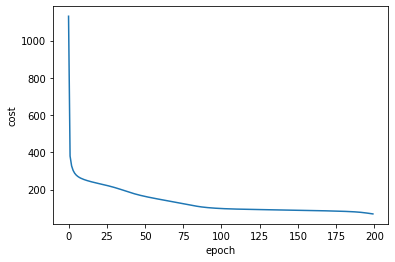

In [20]:
# Definimos los hiperparámetros y entrenamos el modelo
# Entrenamos primero con SGD (tamaño de batch = 1) para lograr copiar mejor la particularidad de la función de entrada
learning_rate = 0.01
optimizer = torch.optim.SGD(modeloTP3.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=1)
criterion = nn.MSELoss()
LOSS = train(data_set,modeloTP3,criterion, train_loader, optimizer, epochs=200,plot_number=10)

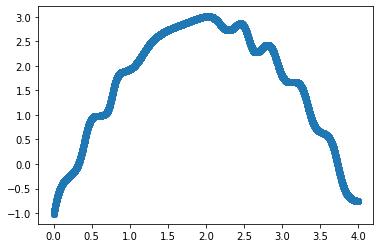

In [21]:
# Graficamos la predicción del modelo respecto a nuestra entrada
yhat = modeloTP3(data_set.x)
plt.scatter(data_set.x,yhat.detach().numpy())

In [24]:
# Volvemos a definir un modelo, ahora para entrenar con un tamaño de batch de 50
modeloTP3_minibatch= modelo()
torchsummary.summary(modeloTP3_minibatch, input_size=(10000, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 10000, 20]              40
              Tanh-2            [-1, 10000, 20]               0
            Linear-3            [-1, 10000, 10]             210
              Tanh-4            [-1, 10000, 10]               0
            Linear-5             [-1, 10000, 1]              11
Total params: 261
Trainable params: 261
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 4.65
Params size (MB): 0.00
Estimated Total Size (MB): 4.69
----------------------------------------------------------------


237.64114892482758
6.098980143666267
4.506154403090477
4.306702738627791
4.220610653050244
4.169688576832414
4.135873642750084
4.111507723107934
4.09285191912204
4.077872412279248
4.065380802378058
4.054649828001857
4.0452121663838625
4.036761070601642
4.0290882140398026
4.0220478205010295
4.015532937832177
4.009464434348047
4.0037842486053705
3.998441924341023


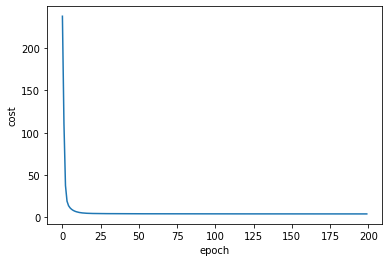

In [25]:
# Definimos los hiperparámetros y entrenamos el modelo
# Entrenamos primero con SGD (tamaño de batch = 50) para lograr copiar mejor la particularidad de la función de entrada
learning_rate = 0.01
optimizer = torch.optim.SGD(modeloTP3_minibatch.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=50)
criterion = nn.MSELoss()
LOSS = train(data_set,modeloTP3_minibatch,criterion, train_loader, optimizer, epochs=200,plot_number=10)

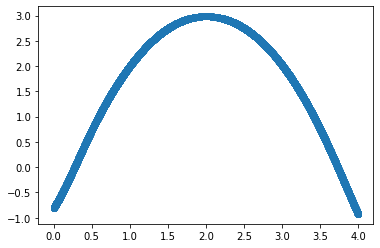

In [26]:
# Graficamos la predicción del modelo respecto a nuestra entrada
yhat_minibatch = modeloTP3_minibatch(data_set.x)
plt.scatter(data_set.x,yhat_minibatch.detach().numpy())

In [ ]:
# Observamos que con un tamaño de batch mayor, el modelo no se "sobreentrena", copiando la forma global de la función